In [29]:
!pip install -q optuna optuna-integration[tfkeras]


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import optuna
import random
import os

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Sequential, Input, optimizers
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import TFKerasPruningCallback

In [31]:
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude JKSE from X

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

N_TRIALS   = 50          # increase for a more thorough search
RANDOM_SEED = 42

Z_LEVEL = 1.96      # ~95% CI
ROLL_WIN = 30       # rolling window for PICP/MPIW
HEAT_WIN = 30       # window length for coverage heatmap
HEAT_STRIDE = 10    # stride between windows in coverage heatmap

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

42


In [32]:
df = pd.read_csv(CSV_PATH)
required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,232.0790,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-02,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,234.9300,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-03,13750.0000,62.2000,2136,12962.5000,2089.7800,14519.9000,240.3580,6986.0000,28123.8203,19531.6309,2108.2900,18024.0605,4480.4639,5140.9370
2015-05-04,13750.0000,62.2000,2136,12980.0000,2090.5100,14467.5000,239.0180,6986.0000,28123.8203,19531.6309,2114.4900,18070.4004,4480.4639,5140.9370
2015-05-05,14245.0000,62.5000,2136,13047.5000,2102.3900,14594.9000,236.1210,6927.6001,27755.5391,19531.6309,2089.4600,17928.1992,4298.7061,5160.1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.8800,93.7500,4057,16830.0000,2309.3700,19127.3000,93754.8438,8415.2998,21980.7402,35705.7383,5525.2100,40113.5000,3295.0601,6678.9150
2025-04-28,15637.6300,95.6000,3943,16855.0000,2310.5900,19251.8000,94978.7500,8417.2998,21971.9609,35839.9883,5528.7500,40227.5898,3288.4150,6722.9658
2025-04-29,15564.0000,97.2500,3911,16760.0000,2305.5200,19082.1000,94284.7891,8463.5000,22008.1094,35839.9883,5560.8301,40527.6211,3286.6550,6749.0752


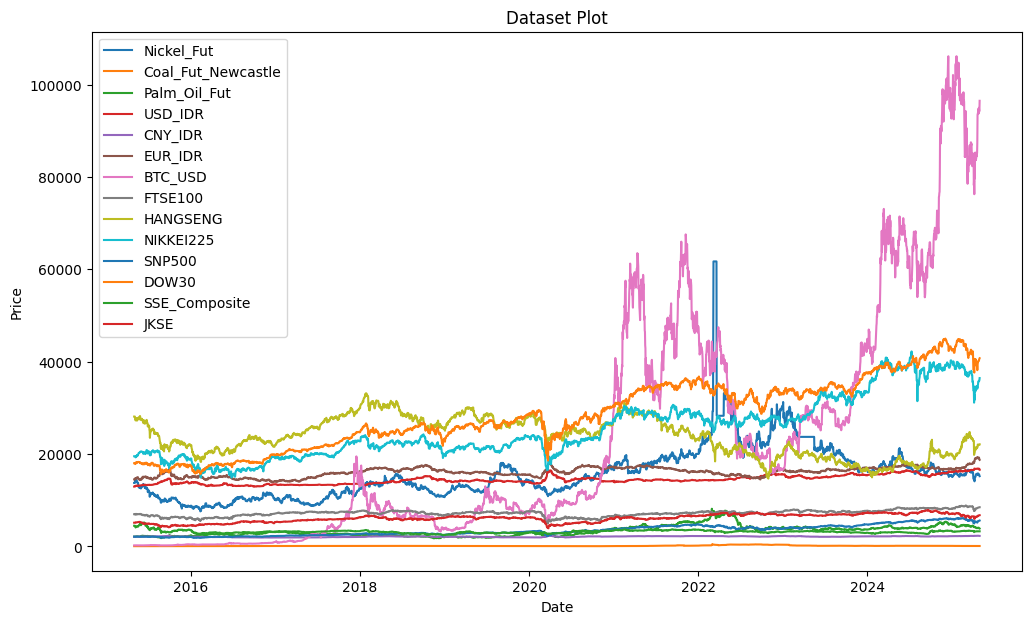

In [33]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [34]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [35]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]

In [36]:
# feature_cols = [c for c in df.columns if c != TARGET_COL]
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [37]:
def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

In [38]:
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [39]:
# Heteroscedastic Gaussian NLL Loss
def nll_gaussian_heteroscedastic(y_true, y_pred):
    """
    y_true: (batch,) or (batch,1)
    y_pred: (batch,2) = [mu_s, log_var_s]
    """
    y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.float32)  # flatten
    mu      = y_pred[:, 0]
    log_var = tf.clip_by_value(y_pred[:, 1], -20.0, 5.0)     # stability
    inv_var = tf.exp(-log_var)
    nll = 0.5 * (log_var + (y_true - mu)**2 * inv_var)
    return tf.reduce_mean(nll)

In [40]:
def build_gru(trial, lookback, n_features):
    num_layers = trial.suggest_int("num_layers", 1, 2)
    units1     = trial.suggest_int("units1", 32, 256, step=32)
    units2     = trial.suggest_int("units2", 32, 256, step=32) if num_layers == 2 else None
    dropout    = trial.suggest_float("dropout", 0.0, 0.5)
    lr         = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    model = Sequential()
    model.add(Input(shape=(lookback, n_features)))

    if num_layers == 2:
        model.add(GRU(units1, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(GRU(units2))
    else:
        model.add(GRU(units1))

    model.add(Dropout(dropout))
    model.add(Dense(2))  # (mu_s, log_var_s)

    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss=nll_gaussian_heteroscedastic)
    return model

In [41]:
def objective(trial):
    lookback = trial.suggest_categorical("lookback", [30, 45, 60, 90])
    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, lookback)
    X_va, y_va, _ = make_windows(X_val_s,   y_val_s,   lookback)

    # reshape if needed (safe)
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    epochs     = trial.suggest_int("epochs", 30, 100, step=10)
    patience   = trial.suggest_int("patience", 5, 10)

    model = build_gru(trial, lookback, n_features=len(feature_cols))
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        TFKerasPruningCallback(trial, monitor="val_loss"),
    ]

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks,
    )

    return min(history.history["val_loss"])

In [42]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

print("\nStarting Optuna study...")
start_opt = time.time()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
end_opt = time.time()
print(f"Optuna finished in {end_opt - start_opt:.4f} seconds")
print("Best trial:", study.best_trial.number)
print("Best val_loss:", study.best_value)
print("Best params:", study.best_params)

best_params   = study.best_params
BEST_LOOKBACK = best_params["lookback"]

[I 2025-11-27 10:22:56,081] A new study created in memory with name: no-name-bf6b9ae5-ffc2-4384-b26b-ab50f56176ee



Starting Optuna study...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-27 10:24:12,639] Trial 0 finished with value: -1.2773704528808594 and parameters: {'lookback': 45, 'batch_size': 32, 'epochs': 90, 'patience': 8, 'num_layers': 2, 'units1': 32, 'units2': 256, 'dropout': 0.41622132040021087, 'lr': 0.00022948683681130568}. Best is trial 0 with value: -1.2773704528808594.
[I 2025-11-27 10:25:09,275] Trial 1 finished with value: -1.5432274341583252 and parameters: {'lookback': 90, 'batch_size': 128, 'epochs': 40, 'patience': 6, 'num_layers': 1, 'units1': 128, 'dropout': 0.3925879806965068, 'lr': 0.00021839352923182988}. Best is trial 1 with value: -1.5432274341583252.
[I 2025-11-27 10:25:35,534] Trial 2 finished with value: -1.2265710830688477 and parameters: {'lookback': 90, 'batch_size': 128, 'epochs': 100, 'patience': 9, 'num_layers': 1, 'units1': 32, 'dropout': 0.34211651325607845, 'lr': 0.0005595074635794797}. Best is trial 1 with value: -1.5432274341583252.
[I 2025-11-27 10:27:18,683] Trial 3 finished with value: -2.147690534591675 and par

In [43]:
X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST_LOOKBACK)
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST_LOOKBACK)
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST_LOOKBACK)

In [44]:
final_model = Sequential()
final_model.add(Input(shape=(BEST_LOOKBACK, len(feature_cols))))

if best_params["num_layers"] == 2:
    final_model.add(GRU(best_params["units1"], return_sequences=True))
    final_model.add(Dropout(best_params["dropout"]))
    final_model.add(GRU(best_params["units2"]))
else:
    final_model.add(GRU(best_params["units1"]))

final_model.add(Dropout(best_params["dropout"]))
final_model.add(Dense(2))  # heteroscedastic output
final_model.compile(optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
                    loss=nll_gaussian_heteroscedastic)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=best_params["patience"], restore_best_weights=True),
    ModelCheckpoint("Model Checkpoints/gru_optuna_best.keras", monitor="val_loss", save_best_only=True)
]

print("\nRetraining final GRU on TRAIN (validate on VAL)...")
start_train = time.time()
history = final_model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    verbose=1,
    callbacks=callbacks
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.4f} seconds")


Retraining final GRU on TRAIN (validate on VAL)...
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.1161 - val_loss: -0.8728
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: -1.3509 - val_loss: -1.6970
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -1.6114 - val_loss: -1.4777
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: -1.6856 - val_loss: -1.9332
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -1.8021 - val_loss: -1.8658
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -1.8649 - val_loss: -1.9432
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -1.8703 - val_loss: -1.9619
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: -1.9603 - val_loss: -1.5662
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -1.9461 - val_loss: -1.8673
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -1.9486 - val_loss: -2.1626
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: -2.0176 - val_loss

In [45]:
# Last-Layer Laplace Approximation (LLLA)
# last layer is Dense(2), so penultimate layer is layers[-2]
# _ = final_model.predict(X_train_w[:1], verbose=0)
penultimate_layer = final_model.layers[-2]

phi_model = tf.keras.Model(
    inputs=final_model.layers[0].input,
    outputs=penultimate_layer.output  # φ(x)
)

# Get features for each split
phi_train = phi_model.predict(X_train_w, verbose=0)  # (N_train, H)
phi_val   = phi_model.predict(X_val_w,   verbose=0)  # (N_val,   H)
phi_test  = phi_model.predict(X_test_w,  verbose=0)  # (N_test,  H)

print("phi_train shape:", phi_train.shape)
print("phi_val shape:",   phi_val.shape)
print("phi_test shape:",  phi_test.shape)

phi_train shape: (2542, 192)
phi_val shape: (202, 192)
phi_test shape: (640, 192)


In [46]:
# Get MAP predictions in scaled space for training data
yhat_train_s = final_model.predict(X_train_w, verbose=0)   # (N_train, 2)
mu_train_s   = yhat_train_s[:, 0]                          # only mean head

# y_train_w is already scaled (comes from y_train_s via make_windows)
y_true_train_s = y_train_w  # (N_train,)

# Estimate noise variance σ_n^2 in scaled space
residuals_train_s = y_true_train_s - mu_train_s
sigma_n2 = np.mean(residuals_train_s**2)
print("Estimated noise variance (scaled):", sigma_n2)

Estimated noise variance (scaled): 0.0037669209


In [47]:
# Build extended features Φ = [φ, 1] for bias
N_train, H = phi_train.shape

Phi_train = np.concatenate(
    [phi_train, np.ones((N_train, 1), dtype=phi_train.dtype)],
    axis=1
)  # shape (N_train, H+1)

# Prior precision (ridge term)
lambda_prior = 1.0  # you can tune this (e.g., 1.0, 0.1, 10.0)

# Diagonal Hessian approximation: H_diag = (1/σ_n^2) * sum_i φ_i^2 + λ
H_diag = (1.0 / sigma_n2) * np.sum(Phi_train**2, axis=0) + lambda_prior  # (H+1,)

# Posterior variance of weights: diag(Σ) = 1 / H_diag
var_w_diag = 1.0 / H_diag  # (H+1,)

print("var_w_diag shape:", var_w_diag.shape)

var_w_diag shape: (193,)


In [48]:
# Helper to compute epistemic std for any split
y_std = y_scaler.scale_[0]

def compute_sigma_epi(phi_block, idx_block):
    N, H = phi_block.shape
    Phi_block = np.concatenate(
        [phi_block, np.ones((N, 1), dtype=phi_block.dtype)],
        axis=1
    )  # (N, H+1)

    # Var_epi in scaled space: Φ Σ Φ^T (diagonal only with diag Σ)
    var_epi_scaled = np.sum((Phi_block**2) * var_w_diag.reshape(1, -1), axis=1)  # (N,)
    var_epi_orig   = var_epi_scaled * (y_std**2)
    sigma_epi_orig = np.sqrt(np.maximum(var_epi_orig, 1e-12))  # avoid negatives

    return pd.Series(sigma_epi_orig, index=idx_block, name="sigma_epi")

# Compute epistemic std for each split
sigma_epi_train = compute_sigma_epi(phi_train, idx_train)
sigma_epi_val   = compute_sigma_epi(phi_val,   idx_val)
sigma_epi_test  = compute_sigma_epi(phi_test,  idx_test)

print(sigma_epi_train.head())
print(sigma_epi_val.head())
print(sigma_epi_test.head())

2015-07-30   15.1577
2015-07-31   15.0554
2015-08-01   14.4352
2015-08-02   14.4047
2015-08-03   14.3628
Name: sigma_epi, dtype: float32
2022-10-13   22.6010
2022-10-14   22.5731
2022-10-15   22.0513
2022-10-16   22.2108
2022-10-17   22.2730
Name: sigma_epi, dtype: float32
2023-08-01   19.4954
2023-08-02   19.3738
2023-08-03   19.1653
2023-08-04   19.3019
2023-08-05   19.0128
Name: sigma_epi, dtype: float32


In [49]:
def predict_series_hetero(model, X_block, idx_block):
    yhat_s = model.predict(X_block, verbose=0)   # (N,2)
    mu_s = yhat_s[:, 0]
    log_var_s = yhat_s[:, 1]

    # scale back
    mu_orig = mu_s * y_scaler.scale_[0] + y_scaler.mean_[0]
    var_orig = np.exp(log_var_s) * (y_scaler.scale_[0] ** 2)
    sigma_ale = np.sqrt(var_orig)

    df_out = pd.DataFrame({
        "mu": mu_orig,
        "sigma_ale": sigma_ale
    }, index=idx_block)

    return df_out

pred_train = predict_series_hetero(final_model, X_train_w, idx_train)
pred_val   = predict_series_hetero(final_model, X_val_w, idx_val)

start_test = time.time()
pred_test  = predict_series_hetero(final_model, X_test_w, idx_test)
end_test = time.time()

print(f"Testing (inference) time: {end_test - start_test:.4f} seconds")

Testing (inference) time: 0.5277 seconds


In [50]:
# === Combine aleatoric + epistemic ===
sigma_ale_train = pred_train["sigma_ale"]
sigma_ale_val   = pred_val["sigma_ale"]
sigma_ale_test  = pred_test["sigma_ale"]

sigma_total_train = np.sqrt(sigma_ale_train**2 + sigma_epi_train**2)
sigma_total_val   = np.sqrt(sigma_ale_val**2   + sigma_epi_val**2)
sigma_total_test  = np.sqrt(sigma_ale_test**2  + sigma_epi_test**2)

# Attach back to prediction DataFrames for convenience
pred_train["sigma_epi"]   = sigma_epi_train
pred_val["sigma_epi"]     = sigma_epi_val
pred_test["sigma_epi"]    = sigma_epi_test

pred_train["sigma_total"] = sigma_total_train
pred_val["sigma_total"]   = sigma_total_val
pred_test["sigma_total"]  = sigma_total_test

pred_train.head(), pred_val.head(), pred_test.head()

(                  mu  sigma_ale  sigma_epi  sigma_total
 2015-07-30 4685.5957    59.4930    15.1577      61.3936
 2015-07-31 4682.2744    58.6217    15.0554      60.5241
 2015-08-01 4760.4438    56.1323    14.4352      57.9587
 2015-08-02 4760.5117    55.9714    14.4047      57.7953
 2015-08-03 4763.6357    55.7681    14.3628      57.5880,
                   mu  sigma_ale  sigma_epi  sigma_total
 2022-10-13 6879.7158    84.7553    22.6010      87.7170
 2022-10-14 6884.7891    83.4833    22.5731      86.4812
 2022-10-15 6778.9409    86.1256    22.0513      88.9037
 2022-10-16 6796.4028    82.3786    22.2108      85.3203
 2022-10-17 6798.5547    80.4508    22.2730      83.4770,
                   mu  sigma_ale  sigma_epi  sigma_total
 2023-08-01 6883.8379    27.8620    19.4954      34.0053
 2023-08-02 6833.9062    28.4950    19.3738      34.4573
 2023-08-03 6815.5996    29.7989    19.1653      35.4300
 2023-08-04 6866.8760    29.6218    19.3019      35.3555
 2023-08-05 6822.3711    30.4

In [51]:
actual       = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

In [52]:
metrics_train = compute_metrics(actual_train.values, pred_train["mu"].values)
metrics_val   = compute_metrics(actual_val.values,   pred_val["mu"].values)
metrics_test  = compute_metrics(actual_test.values,  pred_test["mu"].values)

metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Train", "Validation", "Test"]
)

pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary (GRU — Optuna best) ===")
print(metrics_df.round(4))


=== Metrics Summary (GRU — Optuna best) ===
                  MSE     MAE     RMSE   MAPE     R²
Train       1882.4181 29.1271  43.3868 0.0052 0.9962
Validation  1637.5086 28.4210  40.4661 0.0042 0.8921
Test       12007.1888 91.6697 109.5773 0.0127 0.8921


In [53]:
residuals = pd.Series(
    actual_test.values - pred_test["mu"].values,
    index=actual_test.index,
    name="Residuals"
)

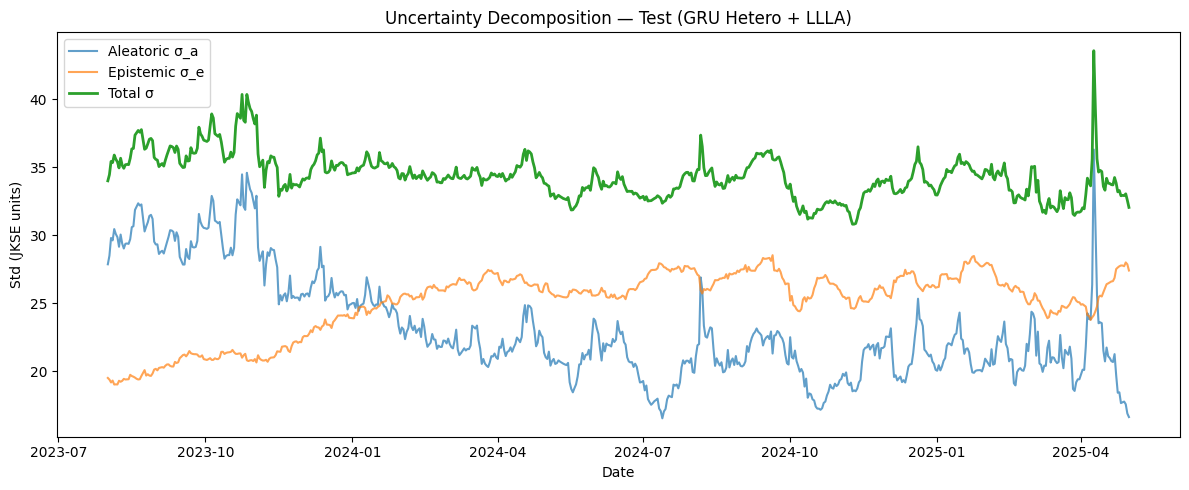

In [54]:
plt.figure(figsize=(12,5))
plt.plot(pred_test.index, pred_test["sigma_ale"],   label="Aleatoric σ_a", alpha=0.7)
plt.plot(pred_test.index, pred_test["sigma_epi"],   label="Epistemic σ_e", alpha=0.7)
plt.plot(pred_test.index, pred_test["sigma_total"], label="Total σ", linewidth=2)
plt.title("Uncertainty Decomposition — Test (GRU Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Std (JKSE units)")
plt.legend(); plt.tight_layout(); plt.show()

In [55]:
# Convenience aliases
mu_train = pred_train["mu"]
mu_val   = pred_val["mu"]
mu_test  = pred_test["mu"]

sigma_ale_train = pred_train["sigma_ale"]
sigma_ale_val   = pred_val["sigma_ale"]
sigma_ale_test  = pred_test["sigma_ale"]

sigma_epi_train  = pred_train["sigma_epi"]
sigma_epi_val    = pred_val["sigma_epi"]
sigma_epi_test   = pred_test["sigma_epi"]

sigma_total_train = pred_train["sigma_total"]
sigma_total_val   = pred_val["sigma_total"]
sigma_total_test  = pred_test["sigma_total"]

# Build total intervals for test set
L_test = mu_test - Z_LEVEL * sigma_total_test
U_test = mu_test + Z_LEVEL * sigma_total_test

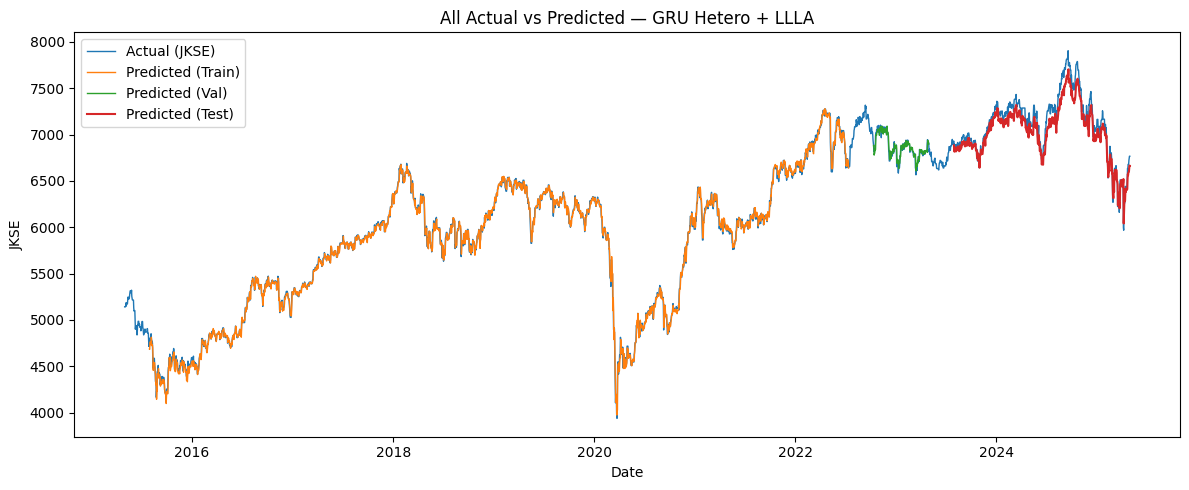

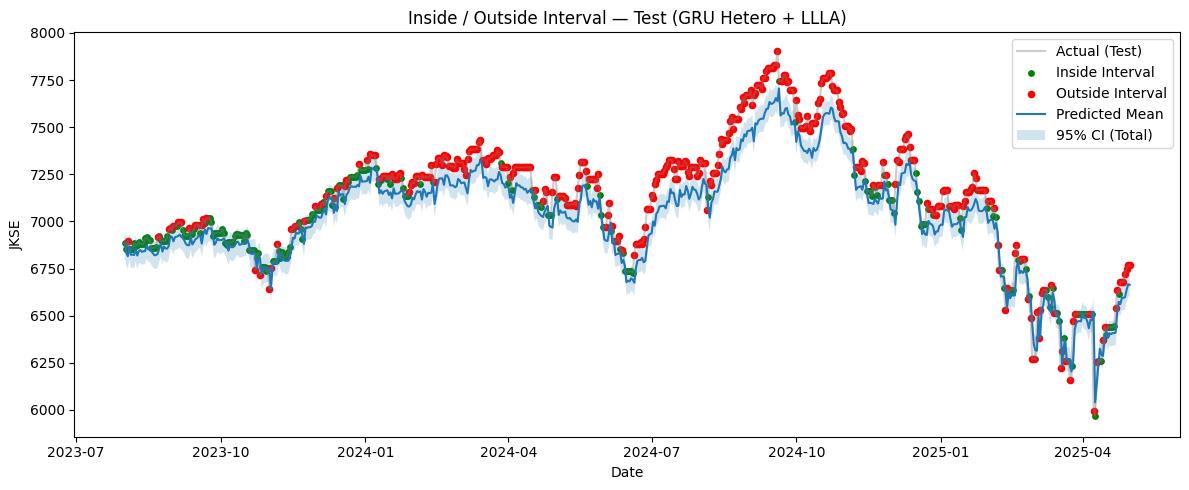

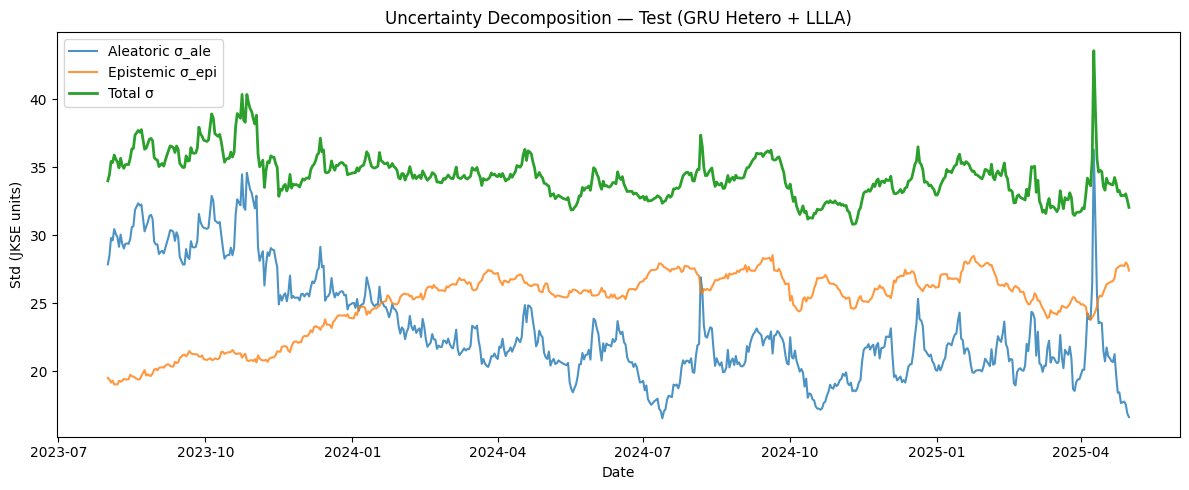

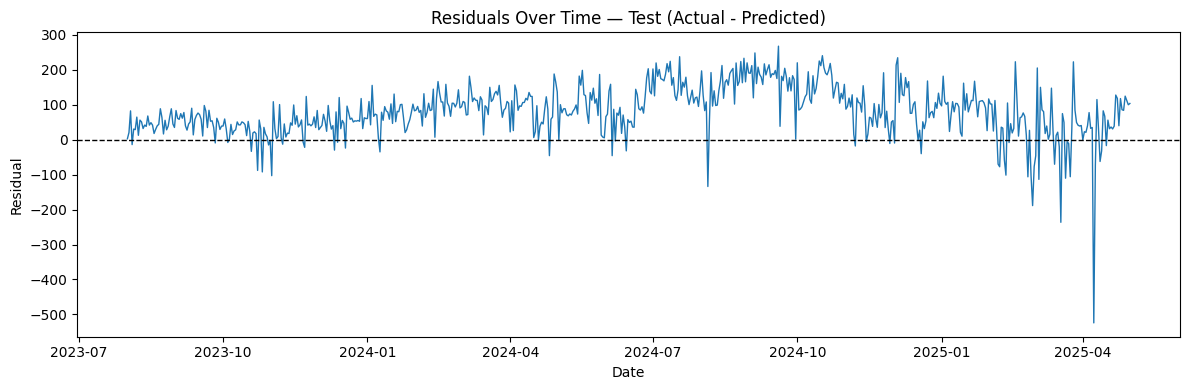

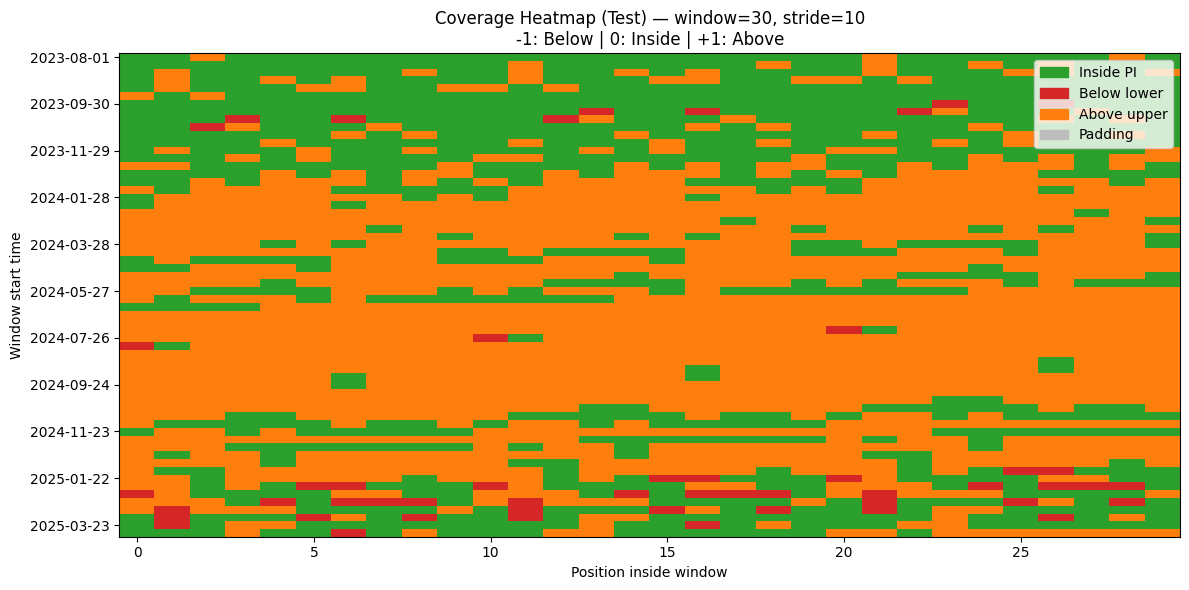

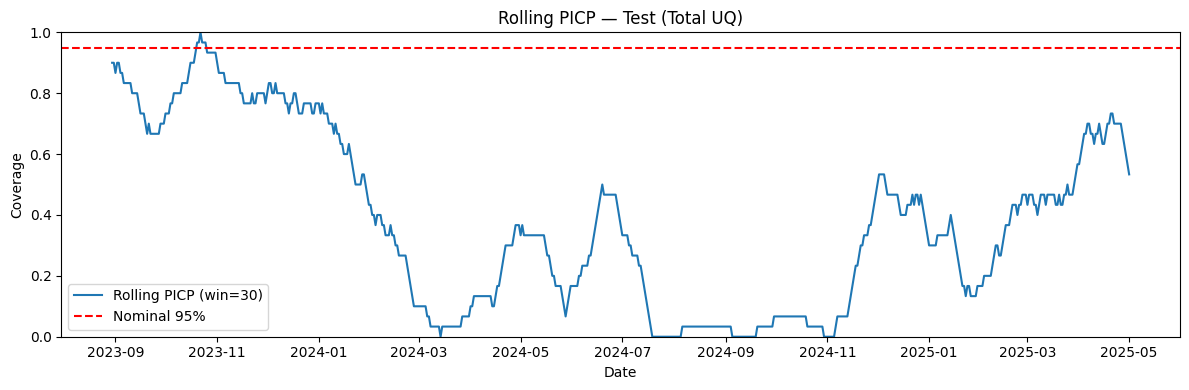

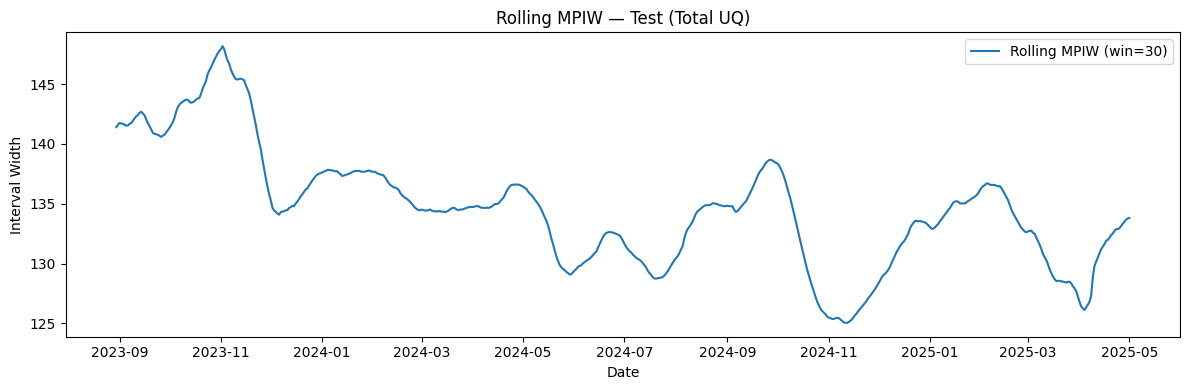

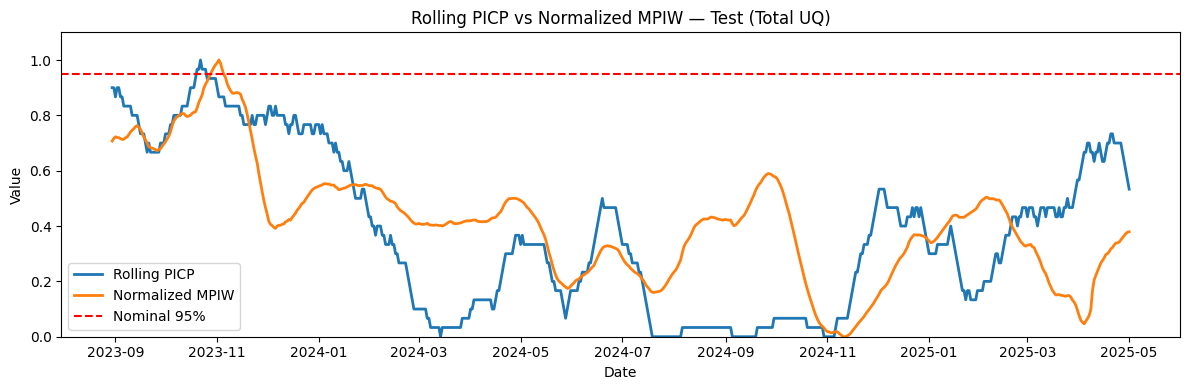

In [ ]:
# (1) ALL ACTUAL vs PREDICTED (Train / Val / Test)
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(mu_train.index, mu_train.values, label="Predicted (Train)", linewidth=1)
plt.plot(mu_val.index,   mu_val.values,   label="Predicted (Val)", linewidth=1)
plt.plot(mu_test.index,  mu_test.values,  label="Predicted (Test)", linewidth=1.5)
plt.title("All Actual vs Predicted — GRU Hetero + LLLA")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (2) INSIDE (GREEN) / OUTSIDE (RED) — TEST ONLY
#    Using TOTAL intervals (aleatoric + epistemic)
y_true_test = actual_test

inside_mask = (y_true_test >= L_test) & (y_true_test <= U_test)
outside_mask = ~inside_mask

plt.figure(figsize=(12, 5))
# Plot actual series in light color
plt.plot(y_true_test.index, y_true_test.values, color="gray", alpha=0.4, label="Actual (Test)")

# Inside points (green)
plt.scatter(
    y_true_test.index[inside_mask],
    y_true_test.values[inside_mask],
    s=15,
    color="limegreen",
    label="Inside Interval"
)

# Outside points (red)
plt.scatter(
    y_true_test.index[outside_mask],
    y_true_test.values[outside_mask],
    s=20,
    color="red",
    label="Outside Interval"
)

plt.plot(mu_test.index, mu_test.values, label="Predicted Mean", linewidth=1.5)
plt.fill_between(mu_test.index, L_test.values, U_test.values, alpha=0.2, label="95% CI (Total)")
plt.title("Inside / Outside Interval — Test (GRU Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (3) UNCERTAINTY DECOMPOSITION — TEST
#     Aleatoric vs Epistemic vs Total
plt.figure(figsize=(12, 5))
plt.plot(sigma_ale_test.index,   sigma_ale_test.values,   label="Aleatoric σ_ale", alpha=0.8)
plt.plot(sigma_epi_test.index,   sigma_epi_test.values,   label="Epistemic σ_epi", alpha=0.8)
plt.plot(sigma_total_test.index, sigma_total_test.values, label="Total σ", linewidth=2)
plt.title("Uncertainty Decomposition — Test (GRU Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Std (JKSE units)")
plt.legend(); plt.tight_layout(); plt.show()

# (4) RESIDUALS OVER TIME — TEST
residuals_test = y_true_test.values - mu_test.values
residuals = np.array(residuals_test)  # just to reuse variable name if needed

plt.figure(figsize=(12, 4))
plt.plot(y_true_test.index, residuals_test, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1, color="black")
plt.title("Residuals Over Time — Test (Actual - Predicted)")
plt.xlabel("Date"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# (5) COVERAGE HEATMAP (PER-WINDOW) — TEST
#     Using TOTAL intervals (aleatoric + epistemic)
y_true = y_true_test.values
L_arr  = L_test.values
U_arr  = U_test.values

below_mask  = (y_true < L_arr)
above_mask  = (y_true > U_arr)
inside_mask = (y_true >= L_arr) & (y_true <= U_arr)

# status: -1 (below), 0 (inside), +1 (above)
status = np.zeros_like(y_true, dtype=float)
status[below_mask] = -1
status[above_mask] = 1

# sliding windows over status
starts = np.arange(0, len(status) - HEAT_WIN + 1, HEAT_STRIDE)
if len(starts) == 0:
    starts = np.array([0])
    HEAT_WIN = len(status)

mat = []
x_tick_labels = []

for s in starts:
    e = min(s + HEAT_WIN, len(status))
    row = status[s:e]
    # pad shorter last row with NaN (for gray)
    if e - s < HEAT_WIN:
        row = np.pad(row, (0, HEAT_WIN - (e - s)), constant_values=np.nan)
    mat.append(row)
    x_tick_labels.append(y_true_test.index[s].strftime("%Y-%m-%d"))

mat = np.vstack(mat)

# colormap: green (inside), red (below), orange (above), gray (padding)
cmap = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(12, 6))
# Note: status mapping: -1, 0, +1; NaN will pick last color (padding)
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.title(f"Coverage Heatmap (Test) — window={HEAT_WIN}, stride={HEAT_STRIDE}\n-1: Below | 0: Inside | +1: Above")
plt.xlabel("Position inside window")
plt.ylabel("Window start time")

# y-axis ticks (window start dates)
yticks = np.arange(0, len(starts), max(1, len(starts) // 10))
plt.yticks(yticks, [x_tick_labels[i] for i in yticks])

legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Inside PI"),
    mpatches.Patch(color="#d62728", label="Below lower"),
    mpatches.Patch(color="#ff7f0e", label="Above upper"),
    mpatches.Patch(color="#bdbdbd", label="Padding"),
]
plt.legend(handles=legend_patches, loc="upper right", frameon=True)
plt.tight_layout(); plt.show()

# (6) ROLLING PICP — TEST (Total intervals)
covered = ((y_true_test >= L_test) & (y_true_test <= U_test)).astype(int)
rolling_picp = covered.rolling(ROLL_WIN).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, label=f"Rolling PICP (win={ROLL_WIN})")
plt.axhline(0.95, color="red", linestyle="--", label="Nominal 95%")
plt.title("Rolling PICP — Test (Total UQ)")
plt.xlabel("Date"); plt.ylabel("Coverage")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout(); plt.show()

# (7) ROLLING MPIW — TEST (Total intervals)
width = (U_test - L_test)
rolling_mpiw = width.rolling(ROLL_WIN).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_mpiw.index, rolling_mpiw.values, label=f"Rolling MPIW (win={ROLL_WIN})")
plt.title("Rolling MPIW — Test (Total UQ)")
plt.xlabel("Date"); plt.ylabel("Interval Width")
plt.legend()
plt.tight_layout(); plt.show()

# (8) ROLLING PICP + NORMALIZED MPIW — TEST
# normalize MPIW to [0,1]
mpiwn = (rolling_mpiw - rolling_mpiw.min()) / (rolling_mpiw.max() - rolling_mpiw.min() + 1e-12)

plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, label="Rolling PICP", linewidth=2)
plt.plot(mpiwn.index, mpiwn.values, label="Normalized MPIW", linewidth=2)
plt.axhline(0.95, color="red", linestyle="--", label="Nominal 95%")
plt.title("Rolling PICP vs Normalized MPIW — Test (Total UQ)")
plt.xlabel("Date"); plt.ylabel("Value")
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout(); plt.show()